# Temporary Notebook for testing ContourGraph and RegionSlice creation


In [1]:
from collections import defaultdict
from collections import Counter

import pandas as pd
from shapely.geometry import Polygon


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from contours import *
from contour_graph import *
from debug_tools import *
#from structures import *
from region_slice import *
#from structure_set import *
from relations import *


### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

# RegionSlice requirements
- The RegionIndexes used as keys in the dictionary attributes should match across slices as much as possible.
- region MultiPolygons should include islands or relations might mistakenly identify a ring as overlapping whin it is interior to a shell, but exterior to an island.
- boundaries must be kept separate even if they are related to the same region.
- every contour of a given ROI on the same slice should be in the same RegionSlice

In [5]:
def surrounds_example3():
    box10x5 = box_points(10,5)
    circle4_left = circle_points(2, offset_x=-3)
    circle3_right = circle_points(1.5, offset_x=3)
    circle2_left = circle_points(1, offset_x=-3, offset_y=0.5)
    circle2_right = circle_points(1, offset_x=3)
    slice_data = [
        ContourPoints(box10x5, roi=0, slice_index=1.0),
        ContourPoints(circle4_left, roi=0, slice_index=1.0),
        ContourPoints(circle3_right, roi=0, slice_index=1.0),
        ContourPoints(circle2_right, roi=0, slice_index=1.0),
        ContourPoints(circle2_left, roi=1, slice_index=1.0),
        ]
    contour_table, slice_sequence = build_contour_table(slice_data)
    contour_graph_a, slice_sequence = build_contour_graph(contour_table,
                                                        slice_sequence,
                                                        roi=0)
    contour_graph_b, slice_sequence = build_contour_graph(contour_table,
                                                        slice_sequence,
                                                        roi=1)
    region_slice_a = RegionSlice(contour_graph_a, slice_index=1.0)
    region_slice_b = RegionSlice(contour_graph_b, slice_index=1.0)
    return region_slice_a, region_slice_b


# ISSUE: This one is evaluating as *Surrounds*, which is **correct**.

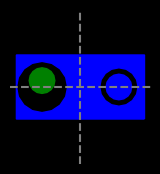

|001|	|111|	|111|
|001|	|001|	|001|
|111|	|001|	|001|

Relationship: Surrounds


In [6]:

a, b = surrounds_example3()
ax = plot_ab(a.regions['0A'], b.regions['1A'])
plt.show()

r = DE27IM(a,b)

print(str(r))
print(r.identify_relation())

In [7]:
box10x5 = box_points(10,5)
circle4_left = circle_points(2, offset_x=-3)
circle3_right = circle_points(1.5, offset_x=3)
circle2_left = circle_points(1, offset_x=-3, offset_y=0.5)
circle2_right = circle_points(1, offset_x=3)
slice_data = [
    ContourPoints(box10x5, roi=0, slice_index=0.0),
    ContourPoints(box10x5, roi=0, slice_index=1.0),
    ContourPoints(box10x5, roi=0, slice_index=2.0),

    ContourPoints(circle4_left, roi=0, slice_index=0.0),
    ContourPoints(circle4_left, roi=0, slice_index=1.0),
    ContourPoints(circle4_left, roi=0, slice_index=2.0),

    ContourPoints(circle3_right, roi=0, slice_index=0.0),
    ContourPoints(circle3_right, roi=0, slice_index=1.0),
    ContourPoints(circle3_right, roi=0, slice_index=2.0),

    ContourPoints(circle2_right, roi=0, slice_index=0.0),
    ContourPoints(circle2_right, roi=0, slice_index=1.0),
    ContourPoints(circle2_right, roi=0, slice_index=2.0),

    ContourPoints(circle2_left, roi=1, slice_index=0.0),
    ContourPoints(circle2_left, roi=1, slice_index=1.0),
    ContourPoints(circle2_left, roi=1, slice_index=2.0)

]

contour_table, slice_sequence = build_contour_table(slice_data)


- Was crashing here because a boundary contour was already created for a contour and then it tries to create a second boundary contour for the same contour.
- Added a try/except to handle this case.
- This is a temporary fix, but it should be removed once the boundary identification is fixed.

In [8]:
contour_graph_a, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=0)
contour_graph_b, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)

In [9]:
a = RegionSlice(contour_graph_a, slice_index=1.0)
b = RegionSlice(contour_graph_b, slice_index=1.0)

# ISSUE: Here the "same" structures are evaluating as *Shelters*, which is **NOT correct**.

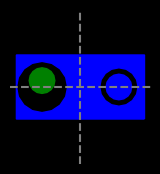

|001|	|001|	|111|
|001|	|001|	|001|
|111|	|111|	|001|

Relationship: Shelters


In [10]:
ax = plot_ab(a.regions['0A'], b.regions['1A'])

r = DE27IM(a,b)

print(str(r))
print(r.identify_relation())

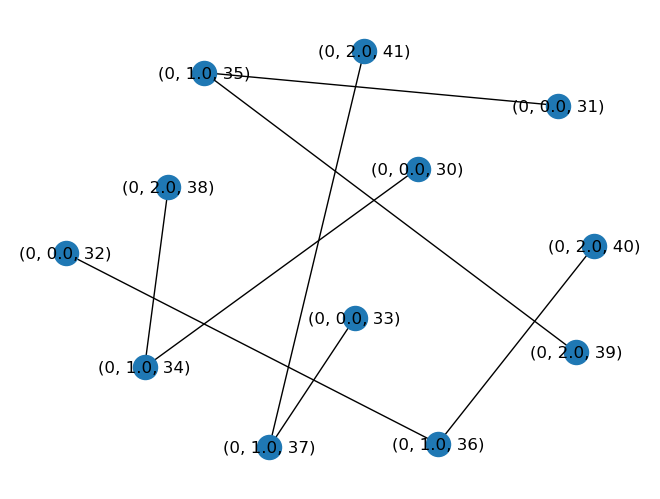

In [11]:
contour_graph = nx.Graph()
roi=0
contour_by_slice = build_contours(contour_table, roi)
for contour_data in contour_by_slice.values():
        for contour in contour_data:
            contour_label = contour.index
            contour_graph.add_node(contour_label, contour=contour)
contour_graph = add_graph_edges(contour_graph, slice_sequence)

nx.draw(contour_graph, with_labels=True,
           pos=nx.arf_layout(contour_graph))
plt.show()

In [12]:
contour_lookup = build_contour_lookup(contour_graph)

contour_lookup.loc[contour_lookup.ROI==0, ['SliceIndex', 'HoleType', 'Label']]

,SliceIndex,HoleType,Label
0,0.0,None,"(0, 0.0, 30)"
1,0.0,Unknown,"(0, 0.0, 31)"
2,0.0,Unknown,"(0, 0.0, 32)"
3,0.0,None,"(0, 0.0, 33)"
4,1.0,None,"(0, 1.0, 34)"
5,1.0,Unknown,"(0, 1.0, 35)"
6,1.0,Unknown,"(0, 1.0, 36)"
7,1.0,None,"(0, 1.0, 37)"
8,2.0,None,"(0, 2.0, 38)"
9,2.0,Unknown,"(0, 2.0, 39)"


# Using degree = 1 to identify boundaries will miss some boundaries
- If there is a bifurcation in the contour on the slice before the boundary the degree will be 2, for a boundary contour.
- degree = 1 is a sufficient to identify boundaries, but not a necessary condition for a boundary.
- if degree > 1, but all edges point in the same (SliceIndex) direction, then it is also a boundary.

In [13]:
[(node, degree) for node, degree in contour_graph.degree()]

[((0, 0.0, 30), 1),
 ((0, 0.0, 31), 1),
 ((0, 0.0, 32), 1),
 ((0, 0.0, 33), 1),
 ((0, 1.0, 34), 2),
 ((0, 1.0, 35), 2),
 ((0, 1.0, 36), 2),
 ((0, 1.0, 37), 2),
 ((0, 2.0, 38), 1),
 ((0, 2.0, 39), 1),
 ((0, 2.0, 40), 1),
 ((0, 2.0, 41), 1)]

In [14]:
boundary_nodes = {node for node, degree in contour_graph.degree()
                    if degree == 1}
boundary_nodes

{(0, 0.0, 30),
 (0, 0.0, 31),
 (0, 0.0, 32),
 (0, 0.0, 33),
 (0, 2.0, 38),
 (0, 2.0, 39),
 (0, 2.0, 40),
 (0, 2.0, 41)}

In [15]:

circle6 = circle_points(3)
circle5 = circle_points(2.5)
circle4 = circle_points(2)
circle3 = circle_points(1.5)
circle2 = circle_points(1)
slice_data = [
    ContourPoints(circle6, roi=0, slice_index=0.0),
    ContourPoints(circle6, roi=0, slice_index=1.0),
    ContourPoints(circle6, roi=0, slice_index=2.0),
    ContourPoints(circle5, roi=0, slice_index=0.0),
    ContourPoints(circle5, roi=0, slice_index=1.0),
    ContourPoints(circle5, roi=0, slice_index=2.0),
    ContourPoints(circle2, roi=0, slice_index=0.0),
    ContourPoints(circle2, roi=0, slice_index=1.0),
    ContourPoints(circle2, roi=0, slice_index=2.0),
    ContourPoints(circle4, roi=1, slice_index=0.0),
    ContourPoints(circle4, roi=1, slice_index=1.0),
    ContourPoints(circle4, roi=1, slice_index=2.0),
    ContourPoints(circle3, roi=1, slice_index=0.0),
    ContourPoints(circle3, roi=1, slice_index=1.0),
    ContourPoints(circle3, roi=1, slice_index=2.0),
]
contour_table, slice_sequence = build_contour_table(slice_data)
contour_graph_a, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=0)
contour_graph_b, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)
a = RegionSlice(contour_graph_a, slice_index=1.0)
b = RegionSlice(contour_graph_b, slice_index=1.0)


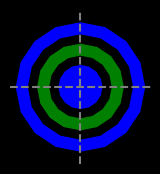

In [16]:
ax = plot_ab(a.regions['0A'], b.regions['1A'])


In [17]:

r = DE27IM(a,b)

print(str(r))
print(r.identify_relation())


|001|	|001|	|111|
|001|	|001|	|001|
|111|	|111|	|001|

Relationship: Shelters
